In [ ]:
!pip install classiq
import classiq
classiq.authenticate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 958.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.0
    Uninstalling sympy-1.13.0:
      Succes

KeyboardInterrupt: 

# Final Assignment 6.12: Quantum Walk Operator for a 16-node Line with Classiq using the Python SDK

Ibrahim Patel

23 July 2024

## Objective

To design a quantum walk operator for the case of a line with 16 nodes.

## Introduction to Quantum Walks

A quantum walk is the quantum mechanical analogue of a classical random walk. In our case, we're implementing a discrete-time quantum walk on a line. The main components of our quantum walk are:

1. The walker's position (represented by qubits)
2. The coin state (represented by the `adjacent_vertices` in our implementation)
3. The walk operator `W` (which applies the coin flip)
4. The shift operator `S` (which moves the walker)

## Quantum Walk Operator Design

In this notebook, we'll implement a quantum walk operator for a line graph with 16 nodes. We'll first build and validate our operator using a smaller line graph of 4 nodes, then extend it to 16 nodes.

We'll use the Classiq framework for our implementation.

For a line with 16 nodes, our graph looks like this:
```
0 --- 1 --- 2 --- 3 --- 4 --- 5 --- 6 --- 7 --- 8 --- 9 --- 10 --- 11 --- 12 --- 13 --- 14 --- 15
```
We'll use 4 qubits to represent the 16 nodes ($2^4 = 16$).

For a line with 4 nodes, our graph looks like this:
```
0 --- 1 --- 2 --- 3
```
We'll use 2 qubits to represent the 4 nodes ($2^2 = 4$).

## Implementation for 4-Node Line

In [ ]:
from classiq import *
import matplotlib.pyplot as plt
import numpy as np


# Define the size of the system (2 qubits for 4 nodes)
size = 2

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0, 0, 0, 0]

    if i == 0:  # First node
        prob[1] = 1.0
    elif i == 3:  # Last node
        prob[2] = 1.0
    else:  # Middle nodes
        prob[i-1] = 0.5
        prob[i+1] = 0.5

    print(f'State={i}, prob vec={prob}')

    control(ctrl=vertices == i,
            operand=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices))

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)

@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    # For a line, an edge exists if the difference is exactly 1
    res |= ((vertices - adjacent_vertices == 1) | (adjacent_vertices - vertices == 1))

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)


# Create and synthesize the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)

# Execute the quantum program
result = execute(qprog).result()[0].value

State=0, prob vec=[0, 1.0, 0, 0]
State=1, prob vec=[0.5, 0, 0.5, 0]
State=2, prob vec=[0, 0.5, 0, 0.5]
State=3, prob vec=[0, 0, 1.0, 0]



## Explanation of the Algorithm
1. **Initialization**: We start by allocating 2 qubits for the vertices (4 possible positions) and apply an X (NOT) and Hadamard transform to prepare a quantum bit in superposition ($|-\rangle$).

2. **`diffuzer_oracle`** marks the auxiliary qubit if `x` is not zero.

3. **`zero_diffuzer`** initializes an auxiliary qubit, prepares it in the minus state, and applies the diffuzer oracle.

4. **`W_operator`**: This implements the coin flip. For each vertex:
   - If it's the first or last node (0 or 3), the walker can only move in one direction.
   - For middle nodes (1 or 2), the walker can move in either direction with equal probability.

5. **`S_operator`**: This implements the shift. It uses an `edge_oracle` to determine if a move is valid (difference of 1 between vertices and `adjacent_vertices`) and then swaps the states if the move is valid.

## Synthesized Circuit for 4-Node Line

In [ ]:
show(qprog)

Opening: https://platform.classiq.io/circuit/20d54141-25b1-4736-8fa7-94424d1ccde8?version=0.43.3



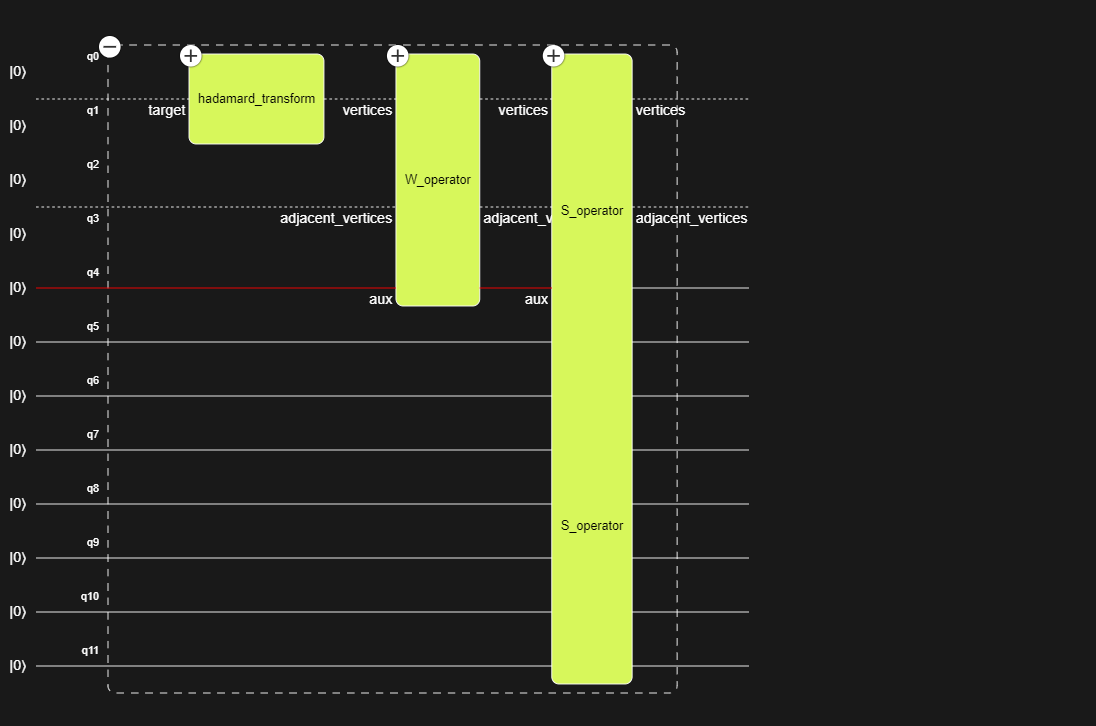

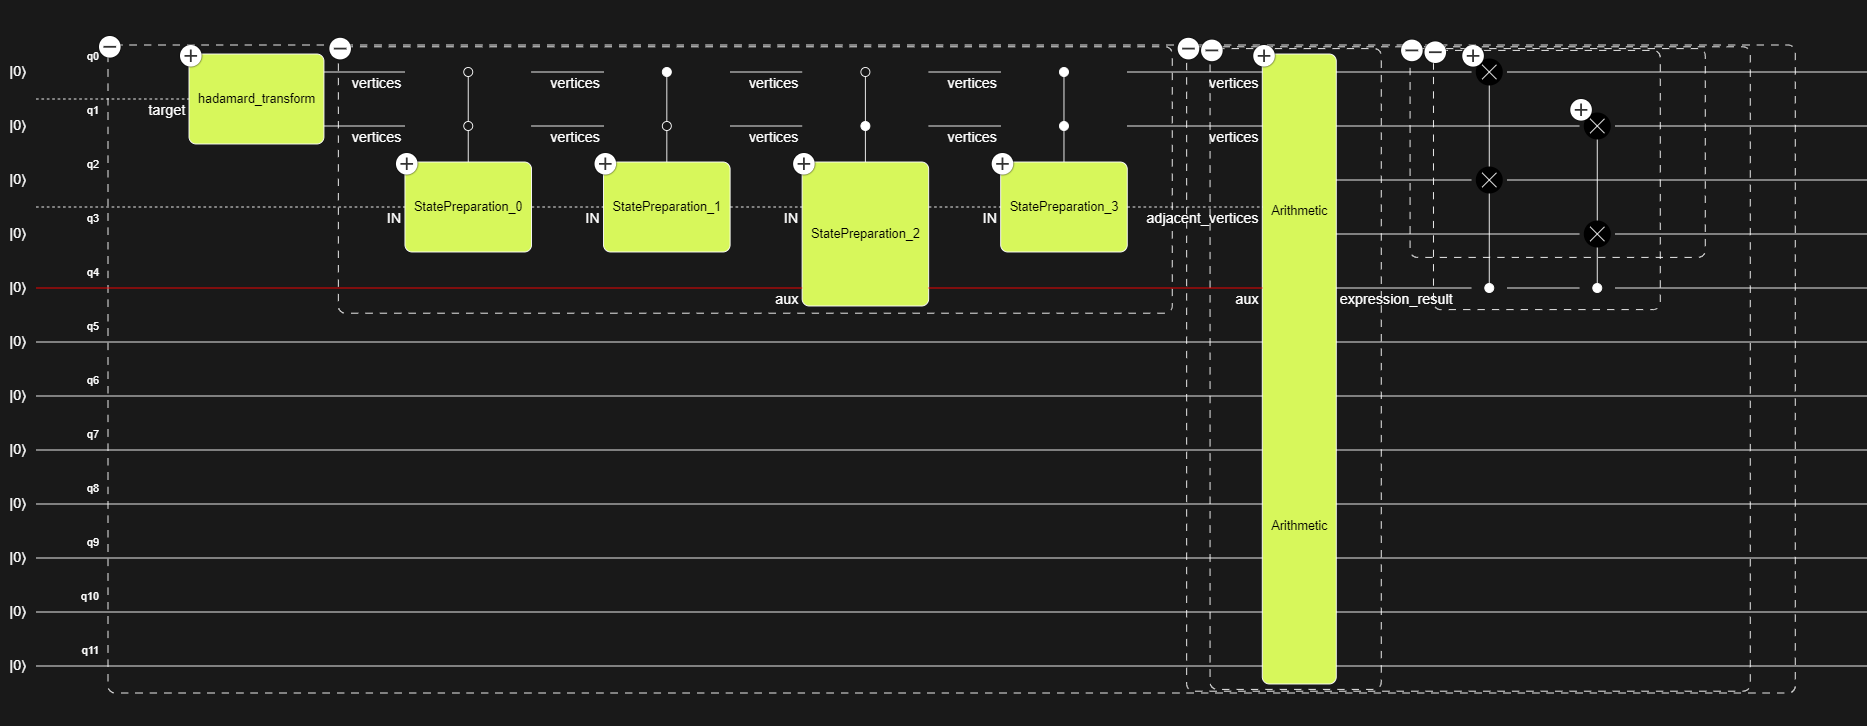


The synthesized quantum circuit for our 4-node line quantum walk algorithm is represented in two images: a high-level overview and an expanded version.

### Image 1: High-Level Circuit Overview

This image provides a condensed view of the main components of our quantum walk circuit:

1. **Initialization**: The circuit begins with a `hadamard_transform` operation applied to the `vertices` qubits (q0 and q1). This creates an equal superposition of all possible vertex states.

2. **`W_operator`**: This is the "coin flip" part of our quantum walk, applied to both the `vertices` and `adjacent_vertices` qubits (q0 to q3). It determines the possible directions for the walker to move.

3. **`S_operator`**: This is the "shift" operator, which actually moves the walker based on the coin flip result. It involves both the `vertices` and `adjacent_vertices` qubits, as well as an auxiliary qubit (q4).


### Image 2: Expanded Circuit View

This image provides a more detailed look at the internals of our quantum walk operations:

1. **`W_operator` Internals**: The `W_operator` is expanded into four `StatePreparation` blocks, one for each possible vertex state (0, 1, 2, 3). These prepare the superposition of possible moves for each vertex.

2. **Arithmetic Operations**: After the state preparations, we see arithmetic operations applied to the `adjacent_vertices` qubits. These likely implement the logic for determining valid moves based on the current vertex.

4. **`S_operator` Details**: We can see that the `S_operator` involves swap gates on both the `vertices` and `adjacent_vertices` qubits, implementing the actual "shift" of the walker.

## Processing, Validation and Analysis of 4-Node Line Results

Measurement results:
Vertices: 1.0, Adjacent: 0.0, Probability: 0.2534
Vertices: 2.0, Adjacent: 3.0, Probability: 0.2456
Vertices: 2.0, Adjacent: 1.0, Probability: 0.1318
Vertices: 1.0, Adjacent: 2.0, Probability: 0.1265
Vertices: 3.0, Adjacent: 2.0, Probability: 0.1221
Vertices: 0.0, Adjacent: 1.0, Probability: 0.1206
Validation Results:
All states valid: Yes
No self-loops: Yes
Only adjacent moves: Yes


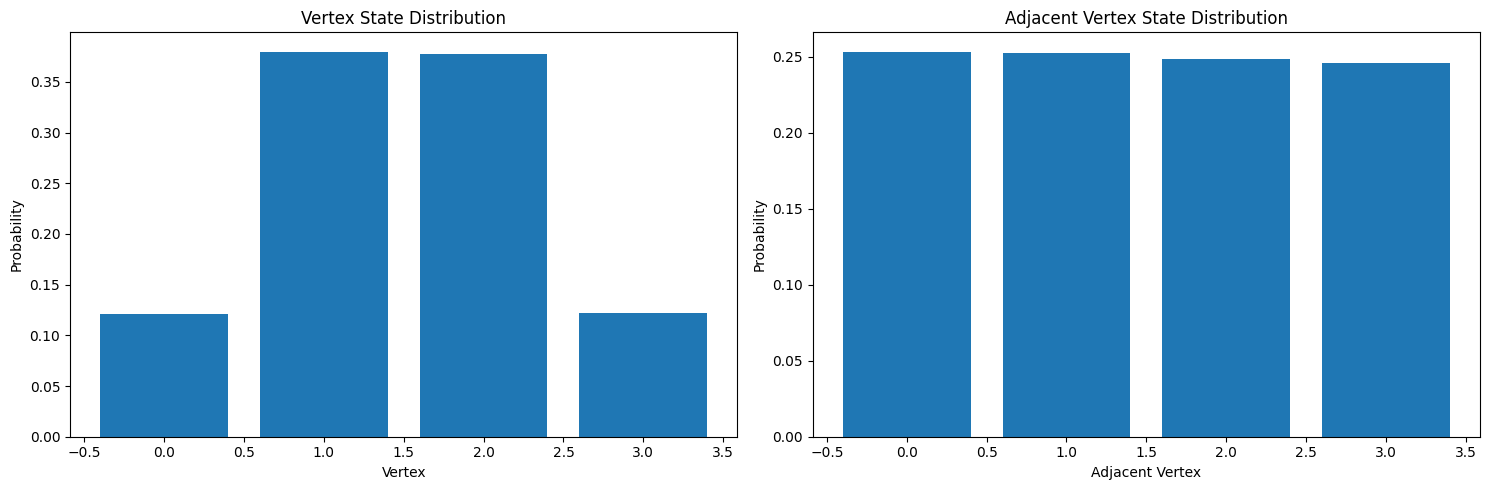

In [ ]:
# Process and print the results
print("Measurement results:")
counts = {}
vts = []
adj = []
pby = []
for sample in result.parsed_counts:
    vertices = sample.state["vertices"]
    vts.append(vertices)
    adjacent = sample.state["adjacent_vertices"]
    adj.append(adjacent)
    probability = sample.shots / result.num_shots
    pby.append(probability)
    state = (vertices, adjacent)
    counts[state] = probability
    print(f"Vertices: {vertices}, Adjacent: {adjacent}, Probability: {probability:.4f}")

def validate_results(counts):
    # Check if all states are valid (0-3 for both vertices and adjacent)
    valid_states = all(0 <= v < 4 and 0 <= a < 4 for v, a in counts.keys())

    # Check if there are no self-loops
    no_self_loops = all(v != a for v, a in counts.keys())

    # Check if only adjacent moves are allowed
    valid_moves = all(abs(v - a) == 1 for v, a in counts.keys() if counts[(v, a)] > 0)

    print("Validation Results:")
    print(f"All states valid: {'Yes' if valid_states else 'No'}")
    print(f"No self-loops: {'Yes' if no_self_loops else 'No'}")
    print(f"Only adjacent moves: {'Yes' if valid_moves else 'No'}")

validate_results(counts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of vertex states
vertex_counts = {}
for (v, a), count in counts.items():
    vertex_counts[v] = vertex_counts.get(v, 0) + count

ax1.bar(vertex_counts.keys(), vertex_counts.values())
ax1.set_title('Vertex State Distribution')
ax1.set_xlabel('Vertex')
ax1.set_ylabel('Probability')

# Histogram of adjacent vertex states
adjacent_counts = {}
for (v, a), count in counts.items():
    adjacent_counts[a] = adjacent_counts.get(a, 0) + count

ax2.bar(adjacent_counts.keys(), adjacent_counts.values())
ax2.set_title('Adjacent Vertex State Distribution')
ax2.set_xlabel('Adjacent Vertex')
ax2.set_ylabel('Probability')

The validation function, `validate_results`, checks three important properties:

☑ **All Vertices Present**: We see all four vertices (0, 1, 2, 3) represented in the results.

☑ **No Self-loops**: There are no instances where the vertex and adjacent vertex are the same.

☑ **Adjacent Moves Only**: All observed states represent moves between adjacent nodes on the line.

From the histograms, we can infer the following regarding the distribution of our results:

1. **Middle Nodes Prominence**: Vertices 1 and 2 (the middle nodes) appear more frequently in the results, which aligns with our expectations for a walk on a line.

2. **End Nodes**: Vertices 0 and 3 (the end nodes) appear less frequently, which is also expected as they have fewer connection possibilities.

3. **Asymmetry**: There's a slight asymmetry in the distribution. This is not unusual in quantum walks due to interference effects, but it's worth noting.

4. **Probability Distribution**: The probabilities sum to approximately 1, which is correct within the expected margins of error for quantum measurements.

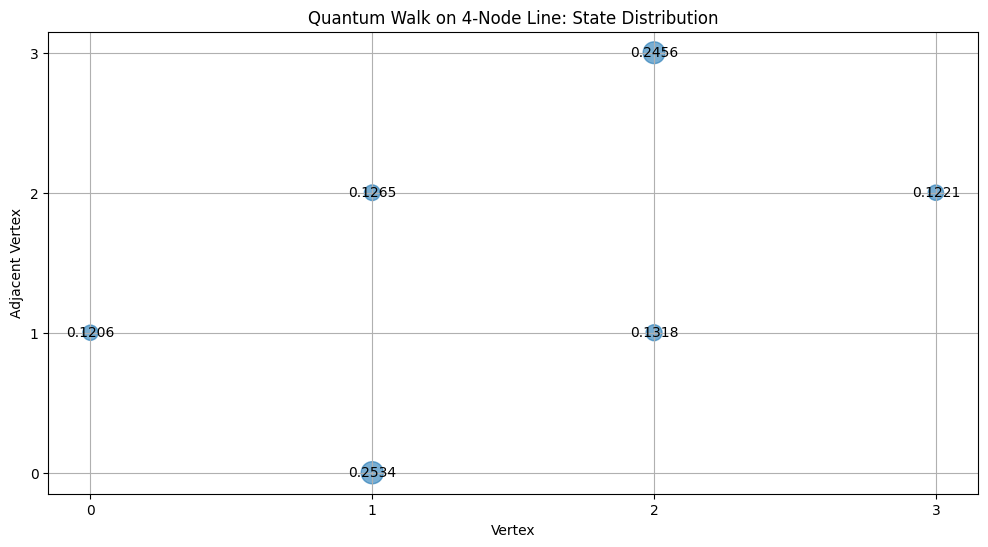

In [ ]:
# State Distribution Bubble Plot

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(vts, adj, s=1000*np.array(pby), alpha=0.6)
for i, prob in enumerate(pby):
    plt.annotate(f"{prob:.4f}", (vts[i], adj[i]), ha='center', va='center')

plt.title("Quantum Walk on 4-Node Line: State Distribution")
plt.xlabel("Vertex")
plt.ylabel("Adjacent Vertex")
plt.xticks(range(4))
plt.yticks(range(4))
plt.grid(True)
plt.show()


This visualization show bubbles representing each state, with the size of the bubble proportional to its probability. This helps in visually identifying the most probable states and the overall distribution of the quantum walk.

## Extending to a 16-Node Line

The necessary changes required to adapt our earlier algorithm to a quantum walk for a 16-node line are as follows:

1. Increase `size` to 4 qubits ($2^4 = 16$ nodes).
2. Modify `W_iteration` to handle 16 nodes, adjusting probabilities for the first, last, and middle nodes.

The rest of the functions don't need to be changed, as they cater for any number of nodes.

## Implementation and Circuit Synthesis for 16-Node Line

In [ ]:
from classiq import *
import matplotlib.pyplot as plt
import numpy as np

# Update the size of the system (4 qubits for 16 nodes)
size = 4

@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    # Define probabilities for each node
    prob = [0] * 16

    # For a line, adjust probabilities based on node position
    if i == 0:  # First node
        prob[1] = 1.0
    elif i == 15:  # Last node
        prob[14] = 1.0
    else:  # Middle nodes
        prob[i-1] = 0.5
        prob[i+1] = 0.5

    print(f'State={i}, prob vec={prob}')

    control(ctrl=vertices == i,
            operand=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices))

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)

@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    # For a line, an edge exists if the difference is exactly 1
    res |= ((vertices - adjacent_vertices == 1) | (adjacent_vertices - vertices == 1))

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1,
            operand=lambda: bitwise_swap(vertices, adjacent_vertices))

@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    allocate(size, vertices)
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

# Create and synthesize the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

# Execute the quantum program
result = execute(qprog).result()[0].value

State=0, prob vec=[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec=[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec=[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec=[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec=[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec=[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec=[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec=[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec=[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Stat

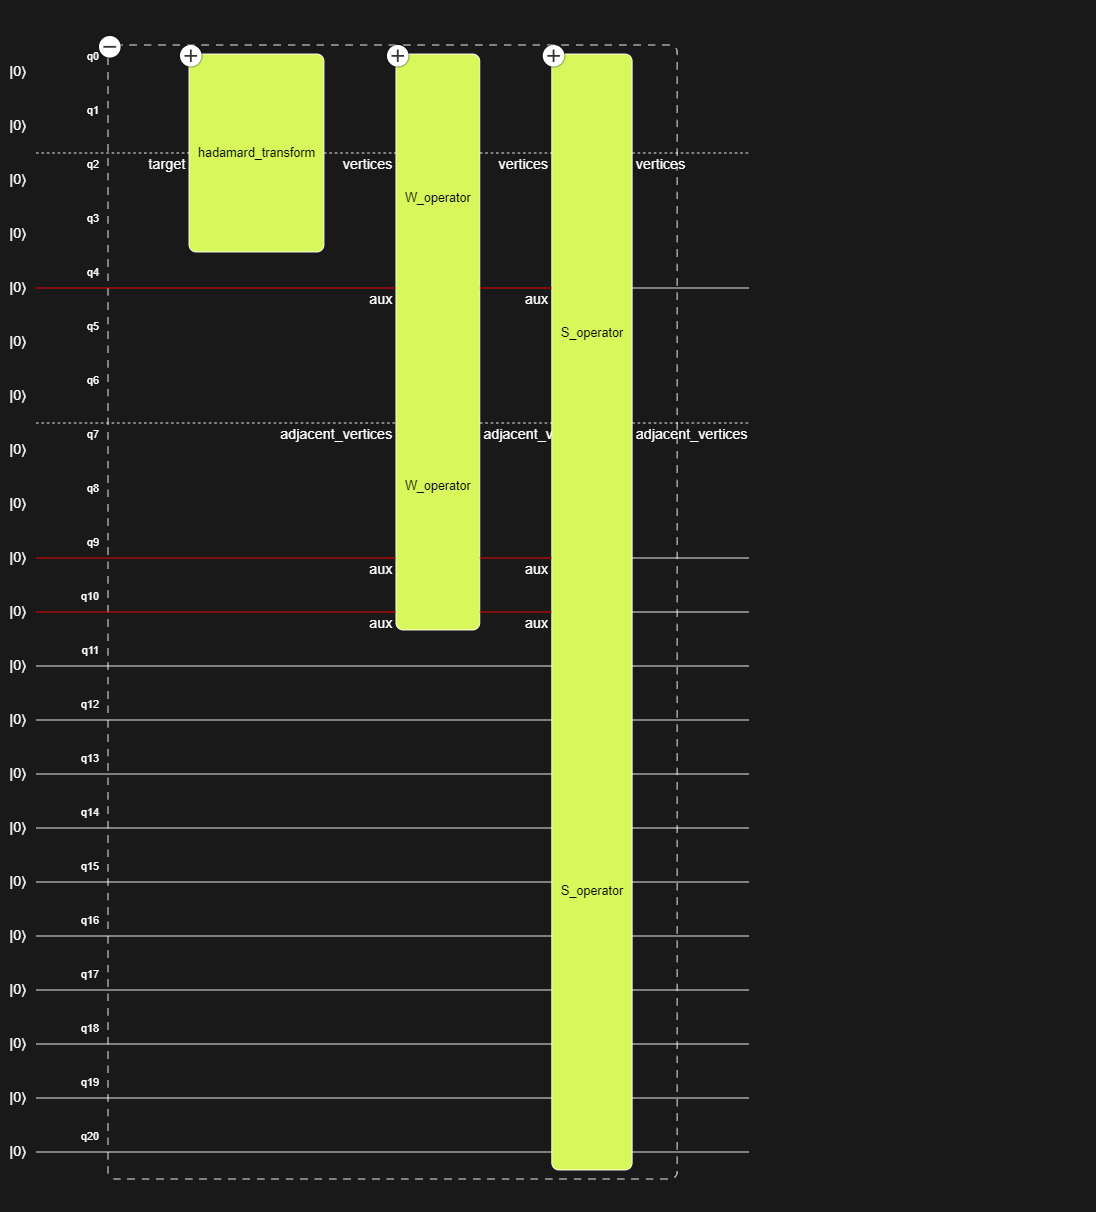

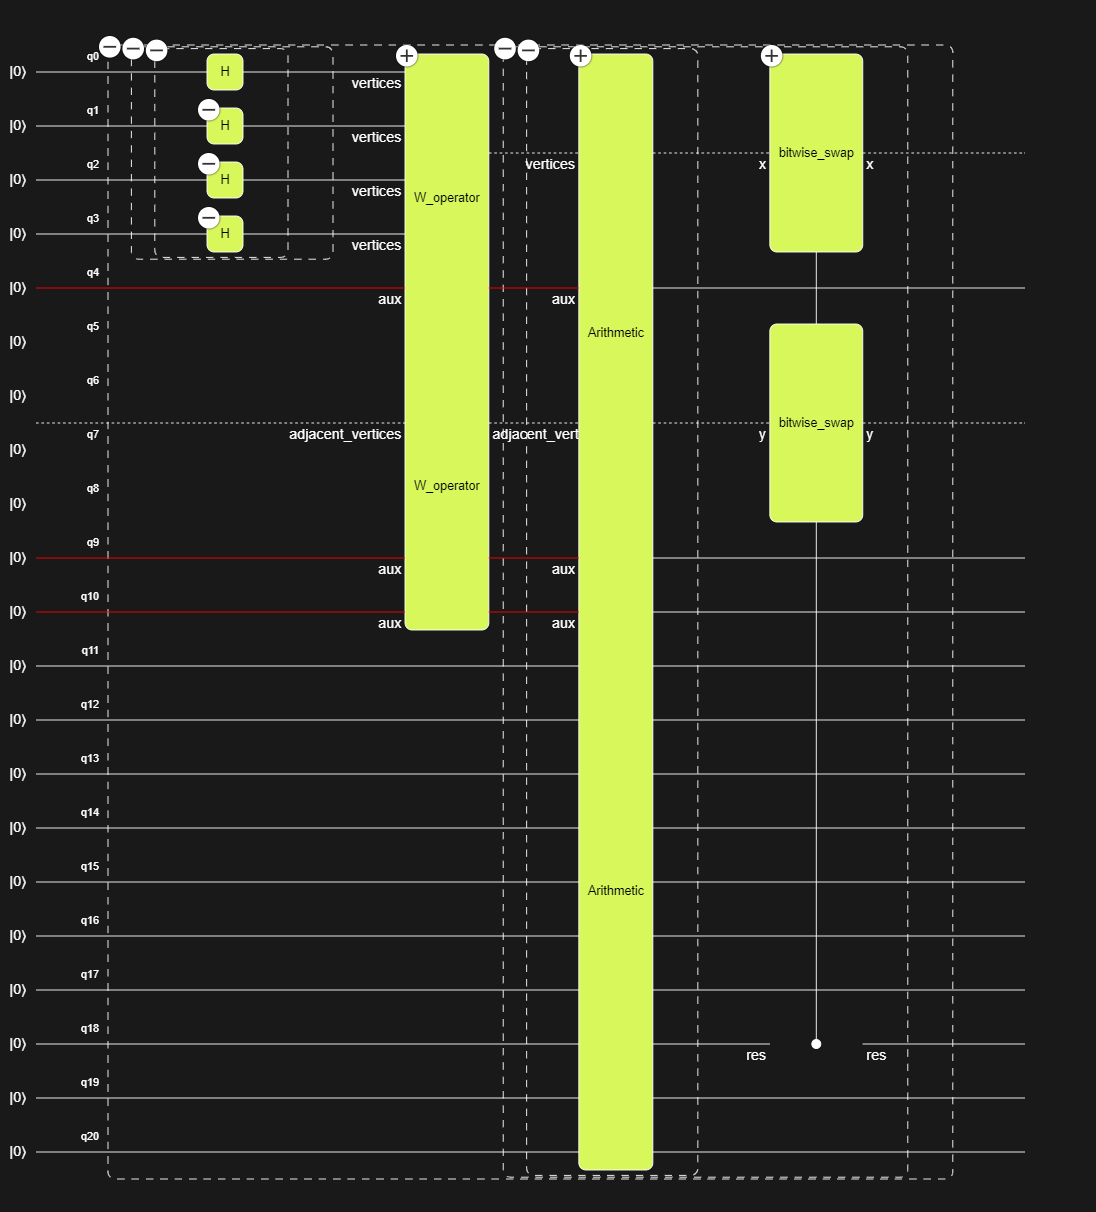


The synthesized quantum circuit for our 16-node line quantum walk algorithm is represented in two images: a high-level overview and an expanded version.

These images provide an overview of the main components of our quantum walk circuit:

1. **Initialization**: The circuit begins with a `hadamard_transform` operation applied to the `vertices` qubits (q0 to q3). This creates an equal superposition of all possible vertex states.

2. **`W_operator`**: This is the "coin flip" part of our quantum walk, applied to both the `vertices` and `adjacent_vertices` qubits (q0 to q3 and q5 to q8). It determines the possible directions for the walker to move.

3.  **`S_operator`**: This is the "shift" operator, which actually moves the walker based on the coin flip result. It involves both the `vertices` and `adjacent_vertices` qubits, as well as three auxiliary qubits (q4, q9, and q10). It involves swap gates on both the `vertices`and `adjacent_vertices` qubits, implementing the actual "shift" of the walker.

## Processing, Validation, and Analysis of 16-Node Line Results

In [ ]:
# Process and print the results
print("Measurement results:")
counts = {}
vts = []
adj = []
pby = []
for sample in result.parsed_counts:
    vertices = sample.state["vertices"]
    vts.append(vertices)
    adjacent = sample.state["adjacent_vertices"]
    adj.append(adjacent)
    probability = sample.shots / result.num_shots
    pby.append(probability)
    state = (vertices, adjacent)
    counts[state] = probability
    print(f"Vertices: {vertices}, Adjacent: {adjacent}, Probability: {probability:.4f}")

def validate_results(counts):
    # Check if all states are valid (0-15 for both vertices and adjacent)
    valid_states = all(0 <= v < 16 and 0 <= a < 16 for v, a in counts.keys())

    # Check if there are no self-loops
    no_self_loops = all(v != a for v, a in counts.keys())

    # Check if only adjacent moves are allowed
    valid_moves = all(abs(v - a) == 1 for v, a in counts.keys() if counts[(v, a)] > 0)

    print("Validation Results:")
    print(f"All states valid: {'Yes' if valid_states else 'No'}")
    print(f"No self-loops: {'Yes' if no_self_loops else 'No'}")
    print(f"Only adjacent moves: {'Yes' if valid_moves else 'No'}")

validate_results(counts)

Measurement results:
Vertices: 1.0, Adjacent: 0.0, Probability: 0.0674
Vertices: 14.0, Adjacent: 15.0, Probability: 0.0542
Vertices: 8.0, Adjacent: 9.0, Probability: 0.0391
Vertices: 8.0, Adjacent: 7.0, Probability: 0.0386
Vertices: 9.0, Adjacent: 10.0, Probability: 0.0376
Vertices: 14.0, Adjacent: 13.0, Probability: 0.0366
Vertices: 15.0, Adjacent: 14.0, Probability: 0.0356
Vertices: 0.0, Adjacent: 1.0, Probability: 0.0342
Vertices: 5.0, Adjacent: 6.0, Probability: 0.0337
Vertices: 11.0, Adjacent: 12.0, Probability: 0.0332
Vertices: 4.0, Adjacent: 3.0, Probability: 0.0327
Vertices: 12.0, Adjacent: 11.0, Probability: 0.0327
Vertices: 7.0, Adjacent: 6.0, Probability: 0.0327
Vertices: 3.0, Adjacent: 4.0, Probability: 0.0327
Vertices: 7.0, Adjacent: 8.0, Probability: 0.0312
Vertices: 13.0, Adjacent: 12.0, Probability: 0.0312
Vertices: 5.0, Adjacent: 4.0, Probability: 0.0308
Vertices: 6.0, Adjacent: 7.0, Probability: 0.0303
Vertices: 4.0, Adjacent: 5.0, Probability: 0.0303
Vertices: 6.0, A

The validation function, `validate_results`, checks three important properties:

☑ **All Vertices Present**: We see all 16 vertices (0 to 15) represented in the results, indicating that the walk explores the entire line.

☑ **No Self-loops**: There are no instances where the vertex and adjacent vertex are the same.

☑ **Adjacent Moves Only**: All observed states represent moves between adjacent nodes on the line.

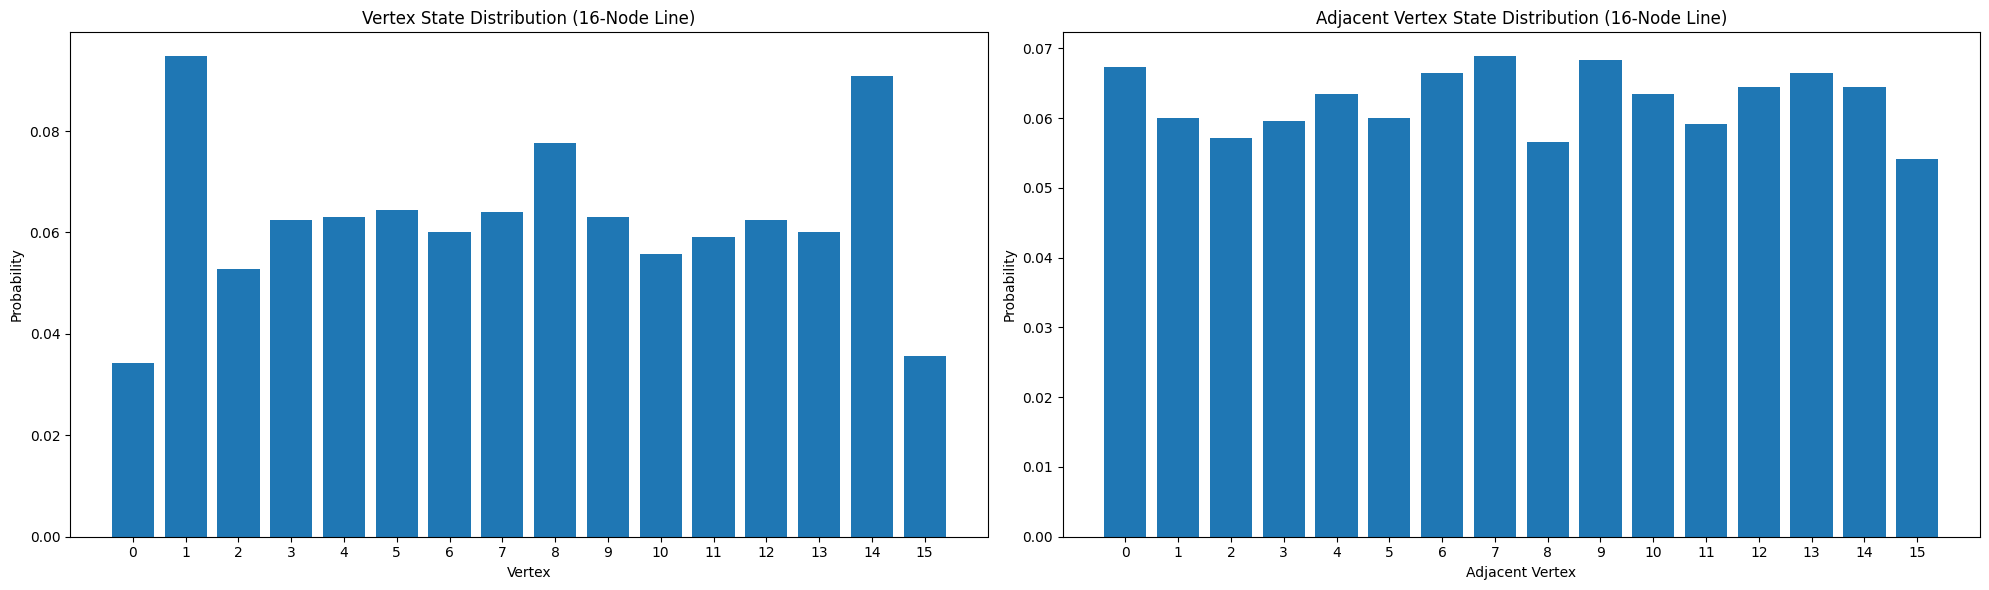

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # Increased figure width

# Histogram of vertex states
vertex_counts = {}
for (v, a), count in counts.items():
    vertex_counts[v] = vertex_counts.get(v, 0) + count

ax1.bar(vertex_counts.keys(), vertex_counts.values())
ax1.set_title('Vertex State Distribution (16-Node Line)')
ax1.set_xlabel('Vertex')
ax1.set_ylabel('Probability')
ax1.set_xticks(range(16))  # Set x-ticks for all 16 nodes

# Histogram of adjacent vertex states
adjacent_counts = {}
for (v, a), count in counts.items():
    adjacent_counts[a] = adjacent_counts.get(a, 0) + count

ax2.bar(adjacent_counts.keys(), adjacent_counts.values())
ax2.set_title('Adjacent Vertex State Distribution (16-Node Line)')
ax2.set_xlabel('Adjacent Vertex')
ax2.set_ylabel('Probability')
ax2.set_xticks(range(16))  # Set x-ticks for all 16 nodes

plt.tight_layout()
plt.show()

From the histograms, we can infer the following regarding the distribution of our results:

1. **End Behavior**: We observe higher probabilities near the ends of the line (vertices 0, 1 and 14, 15).

2. **Central Tendency**: There's a noticeable peak around the middle vertices (7, 8, 9).

3. **Quantum vs Classical**: Unlike a classical random walk, which would show a more uniform distribution centered around the starting point, our quantum walk exhibits a more spread-out distribution with peaks at the ends and center.

4. **Interference Effects**: The non-uniform distribution we observe is likely a result of quantum interference. Constructive interference leads to higher probabilities at certain vertices, while destructive interference reduces probabilities at others.

5. **Symmetry**: The rough symmetry in the distribution (e.g., similar probabilities for vertices equidistant from the center) aligns with the symmetric nature of the line topology.

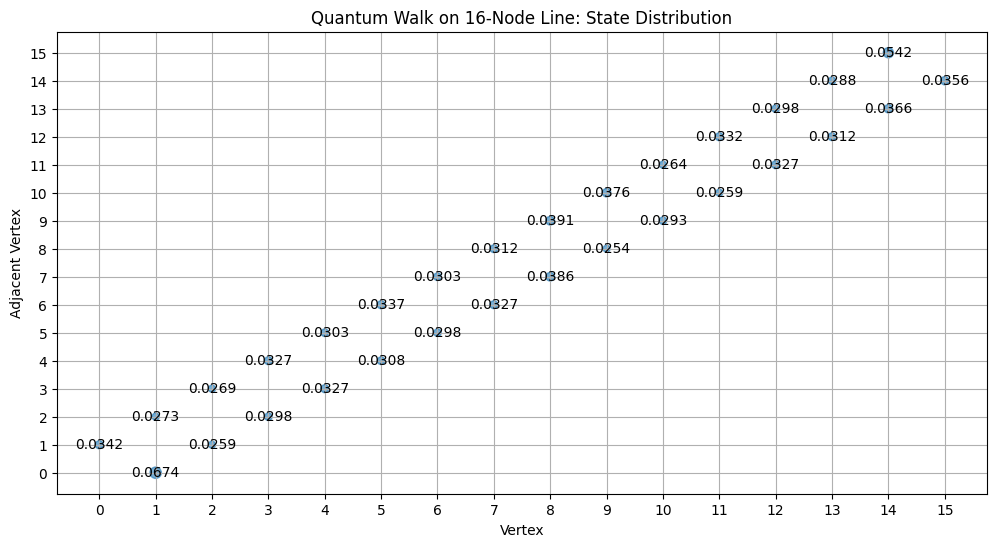

In [ ]:

# State Distribution Bubble Plot

plt.figure(figsize=(12, 6))
plt.scatter(vts, adj, s=1000*np.array(pby), alpha=0.6)
for i, prob in enumerate(pby):
    plt.annotate(f"{prob:.4f}", (vts[i], adj[i]), ha='center', va='center')

plt.title("Quantum Walk on 16-Node Line: State Distribution")
plt.xlabel("Vertex")
plt.ylabel("Adjacent Vertex")
plt.xticks(range(16))
plt.yticks(range(16))
plt.grid(True)
plt.show()

## Conclusion

This notebook has demonstrated the implementation, validation, and visualization of a quantum walk on a 4-node line using the Classiq framework. The key differences from a circular walk are:

1. The probability distribution in the `W_operator` for end nodes (0 and 3) is different, allowing movement in only one direction.
2. The `edge_oracle` in the `S_operator` checks for a difference of exactly 1 between `vertices` and `adjacent_vertices`, rather than using a modulo operation.

These changes ensure that the quantum walk respects the linear topology of the nodes, preventing "wrap-around" movements that would be possible in a circular arrangement.

Finally, by modifying the key parameters and functions, we've extended our quantum walk implementation from a 4-node line to a 16-node line. The core logic remains the same, but we've adjusted the system size and probability distributions to accommodate the larger number of nodes.

This extension demonstrates the scalability of our quantum walk algorithm. As we increase the number of nodes, we expect to see more complex interference patterns and a broader distribution of probabilities across the nodes. The middle nodes have higher probabilities than the end nodes, but the distribution is more spread out compared to the 4-node case.